In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
import warnings
warnings.filterwarnings("ignore")

# from yellowbrick.classifier import ClassPredictionError
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_curve, auc, f1_score, accuracy_score, confusion_matrix, recall_score, precision_score

In [2]:
df = pd.read_csv('p2_reddit.csv')[['text', 'label']]
print(df.shape)
df = df.drop_duplicates()
df

(1010, 2)


,text,label
0,alway taught peopl like jordan peterson matt w...,0
1,don’t actual know qanon hundr leagu past stand...,0
2,f becom concern cousin’ f well relationship cl...,0
3,marri narcissist man littl decad final let go ...,0
4,f brotherinlaw alway total jackass marri siste...,0
...,...,...
1005,cmv uswestern media larg neglect long histori ...,1
1006,agre support idea uk elect head state current ...,1
1007,disagre unit state democrat nation defin const...,1
1008,disagre clear cut side line drawn sand seen pa...,1


In [7]:
df.dropna(inplace = True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 994 entries, 0 to 1009
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    994 non-null    object
 1   label   994 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 23.3+ KB


### Splitting the data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df['text'],
                                                    df['label'],
                                                    stratify = df['label'],
                                                    test_size = 0.2,
                                                    random_state = 1234)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(795,) (199,) (795,) (199,)


In [10]:
y_train.value_counts()

1    402
0    393
Name: label, dtype: int64

In [11]:
v = TfidfVectorizer()

X_train = v.fit_transform(X_train)
X_test = v.transform(X_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(795, 9323) (199, 9323) (795,) (199,)


In [12]:
X_train

<795x9323 sparse matrix of type '<class 'numpy.float64'>'
	with 74438 stored elements in Compressed Sparse Row format>

### Model Training

In [13]:
# def visualizer(clf):
#     visualizer = ClassPredictionError(clf, classes= [0, 1])

#     # Fit the training data to the visualizer
#     visualizer.fit(X_train, y_train)

#     # Evaluate the model on the test data
#     visualizer.score(X_test, y_test)

#     # Draw visualization
#     visualizer.show()
    
def metrics(pred):
    classes = [0, 1]
    matrix = confusion_matrix(y_test, pred, labels = classes)
    mat = matrix.diagonal()/matrix.sum(axis=1)
    print(classification_report(y_test, pred, labels = classes,
                                digits=4))

    print('confusion matrix: ', mat)

    Accuracy = accuracy_score(y_test,pred)
    F1 = f1_score(y_test, pred, average='macro')
    print("Accuracy:", Accuracy)

    rec = recall_score(y_test, pred, average='macro')
    print('Recall: ', rec)
    prec = precision_score(y_test, pred, average='macro')
    print('Precision: ', prec)

    print('F1:', F1)
    
def get_predictions(tpr, fpr, threshold, ypred):
    #If tpr is hight & fpr is low : (tpr*(1-fpr)) is maximum
    actual_ypred = []

    thres = threshold[np.argmax(tpr * (1 - fpr))]
    for value in ypred:
        if value < thres:
            actual_ypred.append(0)
        else:
            actual_ypred.append(1)
    return actual_ypred
    
def get_roc_curve(model_name, classifier):
    
    Ypred_train = classifier.predict(X_train)
    fpr_train, tpr_train, threshold_train = roc_curve(y_train, Ypred_train)
    
    Ypred_test = classifier.predict(X_test)
    fpr_test, tpr_test, threshold_test = roc_curve(y_test, Ypred_test)

    auc_train = round(auc(fpr_train, tpr_train), 4)
    auc_test = round(auc(fpr_test, tpr_test), 4)

    plt.rcParams["figure.figsize"] = [5, 4]
    plt.plot(fpr_train, tpr_train, label = f'train AUC : {auc_train}')
    plt.plot(fpr_test, tpr_test, label = f'test AUC : {auc_test}')
    plt.legend()
    plt.grid()
    plt.title(f'{model_name} ROC Curve')
    plt.xlabel('parameter') 
    plt.ylabel('AUC')
    plt.show()

    roc_results = {
    'ypred_train' : Ypred_train,
    'ypred_test' : Ypred_test,
    'fpr_train' : fpr_train,
    'fpr_test' : fpr_test,
    'tpr_train' : tpr_train,
    'tpr_test' : tpr_test,
    'threshold_train' : threshold_train,
    'threshold_test' : threshold_test
    }
    return roc_results

def get_confusion_matrix(model_name, roc_results):
    actual_ypred_train = get_predictions(roc_results['tpr_train'],
                                         roc_results['fpr_train'],
                                         roc_results['threshold_train'],
                                         roc_results['ypred_train'])

    matrix_train = confusion_matrix(y_train, actual_ypred_train)

    actual_ypred_test = get_predictions(roc_results['tpr_test'],
                                        roc_results['fpr_test'],
                                        roc_results['threshold_test'],
                                        roc_results['ypred_test'])

    matrix_test = confusion_matrix(y_test, actual_ypred_test)

    plt.rcParams["figure.figsize"] = [12, 5]
    plt.rcParams["figure.autolayout"] = True
    f, axes = plt.subplots(1, 2)
    
    axes[0].title.set_text(f'{model_name} Training Confusion Matrix')
    sns.heatmap(matrix_train, annot = True, ax = axes[0], fmt = "d")


    sns.heatmap(matrix_test, annot = True, ax = axes[1], fmt = "d")
    axes[1].title.set_text(f'{model_name} Testing Confusion Matrix')

    return actual_ypred_test, actual_ypred_train

### Random Forest Classifier

In [14]:
randomforest_model = RandomForestClassifier()

parameters = { 'max_depth' : [10, 20, 30],
               'n_estimators' : [90, 150, 180],
               'max_samples' : [0.6, 0.8]
 }

cross_validation = 3
scoring_metric = "f1"
randomforest_model_cv = GridSearchCV(randomforest_model, 
                                     parameters,
                                     cv = cross_validation,
                                     scoring = scoring_metric,
                                     return_train_score=True)

randomforest_model_cv.fit(X_train, y_train)
print('Best Params ', randomforest_model_cv.best_params_)

Best Params  {'max_depth': 30, 'max_samples': 0.8, 'n_estimators': 90}


In [16]:
parameters = {
     'max_depth' : 30,
     'n_estimators' : 90,
     'max_samples' : 0.8
}
randomforest_model = RandomForestClassifier(max_depth = parameters['max_depth'],
                                            max_samples = parameters['max_samples'],
                                            n_estimators = parameters['n_estimators'])

randomforest_model.fit(X_train, y_train)
Ypredtest = randomforest_model.predict_proba(X_test)[:,1]

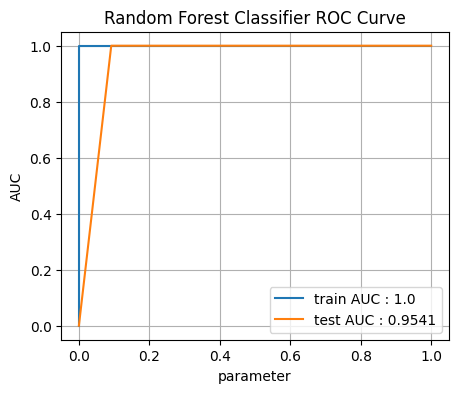

In [17]:
roc_results = get_roc_curve('Random Forest Classifier',
                             randomforest_model)

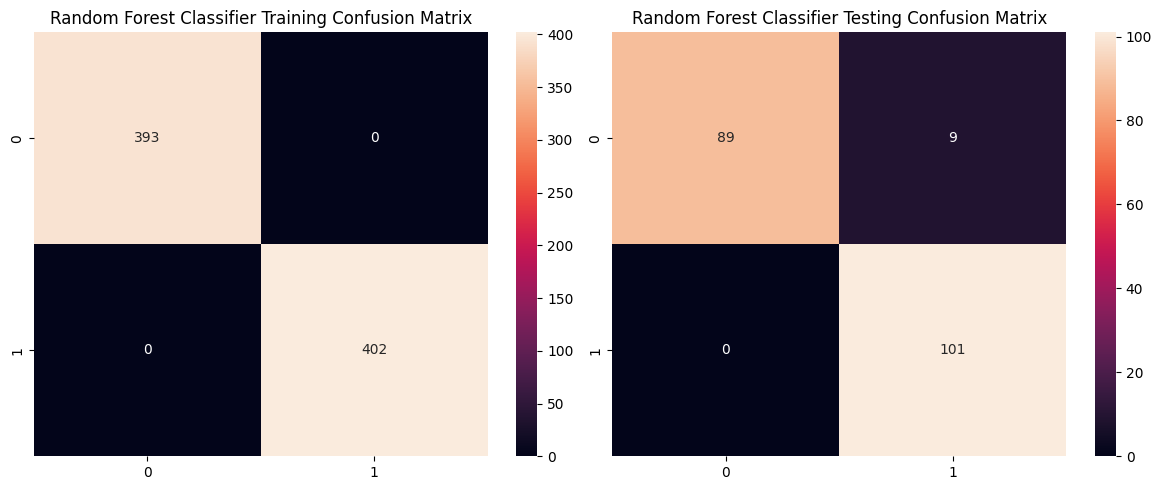

In [18]:
results = get_confusion_matrix('Random Forest Classifier',
                                roc_results)

In [19]:
metrics(results[0])

              precision    recall  f1-score   support

           0     1.0000    0.9082    0.9519        98
           1     0.9182    1.0000    0.9573       101

    accuracy                         0.9548       199
   macro avg     0.9591    0.9541    0.9546       199
weighted avg     0.9585    0.9548    0.9547       199

confusion matrix:  [0.90816327 1.        ]
Accuracy: 0.9547738693467337
Recall:  0.9540816326530612
Precision:  0.9590909090909091
F1: 0.9546088146589959


### Logistic Regression

In [20]:
logistic_model = LogisticRegression()
parameters = { 'C' : [0.01, 0.1, 1, 3, 10],
               'penalty' : ['l2', 'elasticnet']
             }

cross_validation = 3
scoring_metric = "f1"

logistic_model_cv = GridSearchCV(logistic_model,
                                 parameters,
                                 cv = cross_validation,
                                 scoring = scoring_metric,
                                 return_train_score=True)

logistic_model_cv.fit(X_train, y_train)
print('Best Params ', logistic_model_cv.best_params_)

Best Params  {'C': 10, 'penalty': 'l2'}


In [21]:
parameters = { 'C' : 10,
               'penalty' : 'l2'
 }

logistic_model = LogisticRegression(C = parameters['C'], penalty = parameters['penalty'])
logistic_model.fit(X_train, y_train)
Ypredtest = logistic_model.predict_proba(X_test)[:,1]

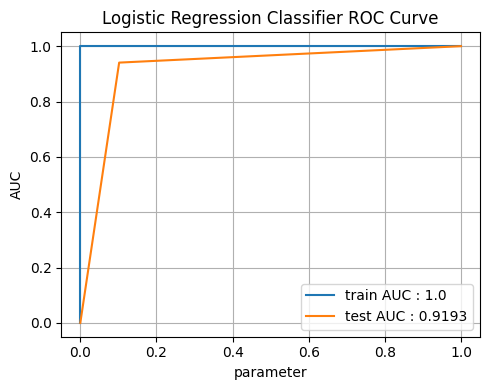

In [22]:
roc_results = get_roc_curve('Logistic Regression Classifier',
                             logistic_model)

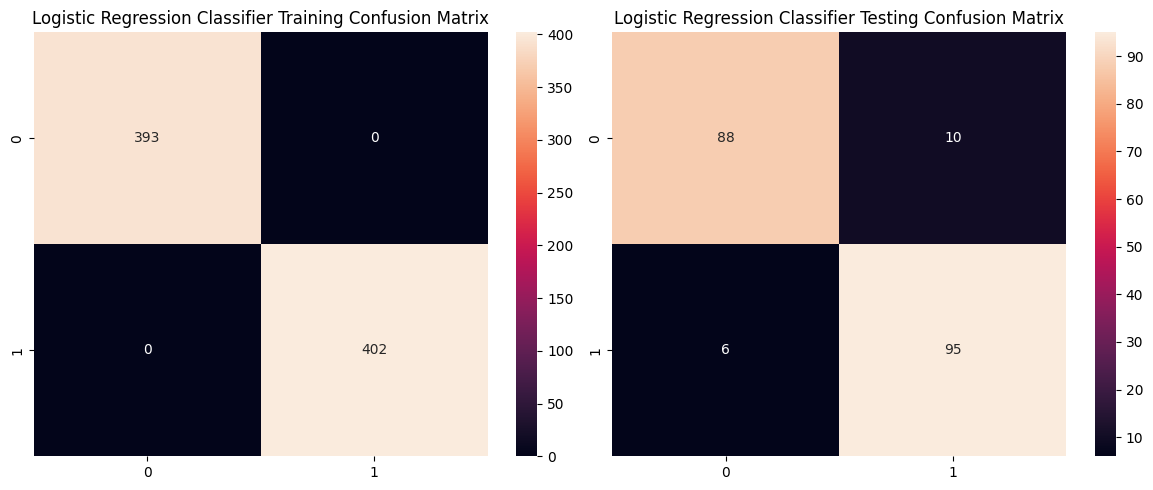

In [23]:
results = get_confusion_matrix('Logistic Regression Classifier',
                                roc_results)

In [24]:
metrics(results[0])

              precision    recall  f1-score   support

           0     0.9362    0.8980    0.9167        98
           1     0.9048    0.9406    0.9223       101

    accuracy                         0.9196       199
   macro avg     0.9205    0.9193    0.9195       199
weighted avg     0.9202    0.9196    0.9195       199

confusion matrix:  [0.89795918 0.94059406]
Accuracy: 0.9195979899497487
Recall:  0.919276621539705
Precision:  0.9204660587639311
F1: 0.9194983818770226


### XG Boost

In [25]:
import xgboost

xgboost_model = xgboost.XGBClassifier()

parameters = { 'max_depth' : [10, 20, 30],
               'n_estimators' : [90, 150, 180],
               'min_child_weight' : [1, 5, 10 ]
 }

cross_validation = 3
scoring_metric = "f1"
xgboost_model_cv = GridSearchCV(xgboost_model, 
                                parameters,
                                cv = cross_validation,
                                scoring = scoring_metric,
                                return_train_score=True)

xgboost_model_cv.fit(X_train, y_train)
print('Best Params ', xgboost_model_cv.best_params_)

Best Params  {'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 180}


In [27]:
parameters = { 'max_depth' : 10,
               'min_child_weight' : 1,
               'n_estimators' : 180
 }

xgboost_model = xgboost.XGBClassifier(max_depth = parameters['max_depth'],
                                      min_child_weight = parameters['min_child_weight'],
                                      n_estimators = parameters['n_estimators'])
xgboost_model.fit(X_train, y_train)
Ypredtest = xgboost_model.predict(X_test)

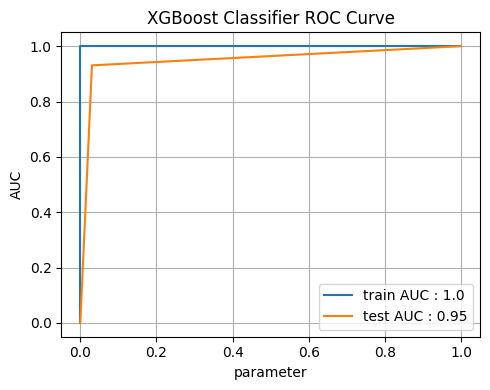

In [28]:
roc_results = get_roc_curve('XGBoost Classifier',
                             xgboost_model)

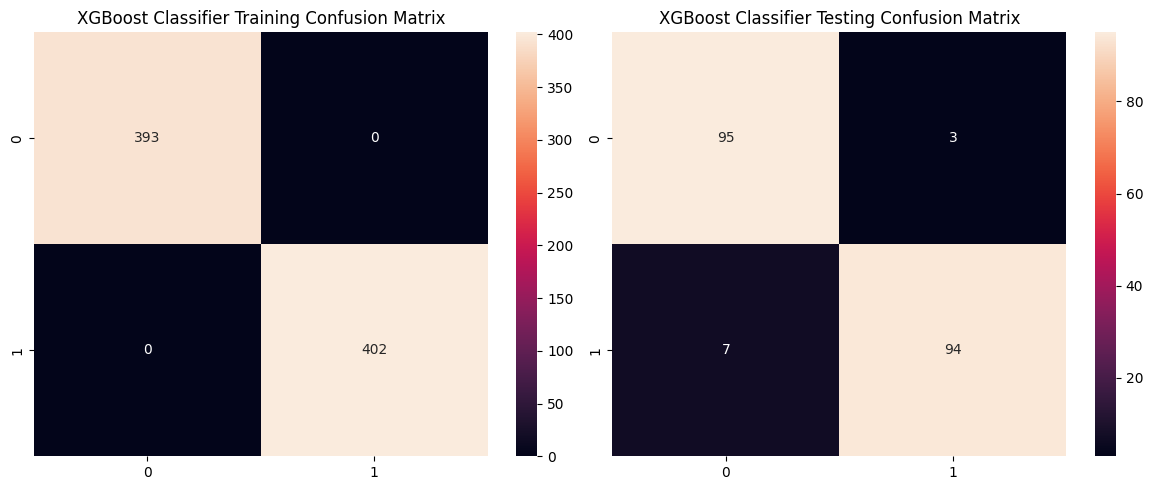

In [29]:
results = get_confusion_matrix('XGBoost Classifier',
                                roc_results)

In [30]:
metrics(results[0])

              precision    recall  f1-score   support

           0     0.9314    0.9694    0.9500        98
           1     0.9691    0.9307    0.9495       101

    accuracy                         0.9497       199
   macro avg     0.9502    0.9500    0.9497       199
weighted avg     0.9505    0.9497    0.9497       199

confusion matrix:  [0.96938776 0.93069307]
Accuracy: 0.949748743718593
Recall:  0.9500404122044858
Precision:  0.9502223569840307
F1: 0.9497474747474748


### SVM

In [31]:
svm_model = SVC()

parameters = { 'kernel' : ['poly', 'rbf', 'sigmoid'],
               'max_iter' : [20, 50, 100]
 }

cross_validation = 3
scoring_metric = "f1"
svm_model_cv = GridSearchCV(svm_model, 
                            parameters,
                            cv = cross_validation,
                            scoring = scoring_metric,
                            return_train_score=True)

svm_model_cv.fit(X_train, y_train)
print('Best Params ', svm_model_cv.best_params_)

Best Params  {'kernel': 'sigmoid', 'max_iter': 100}


In [32]:
parameters = {
         'kernel' : 'sigmoid',
         'max_iter' : 100,
        }

svm_model = SVC(kernel = parameters['kernel'],
max_iter = parameters['max_iter'], probability = True)

svm_model.fit(X_train, y_train)
Ypredtest = svm_model.predict_proba(X_test)[:,1]

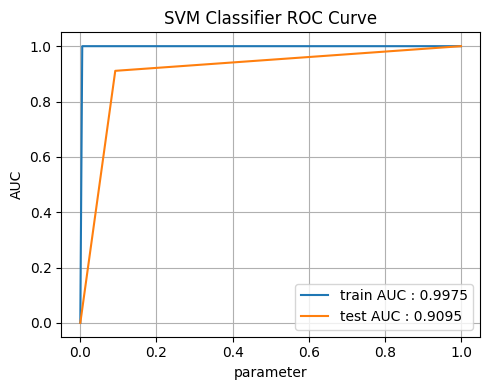

In [33]:
roc_results = get_roc_curve('SVM Classifier',
                             svm_model)

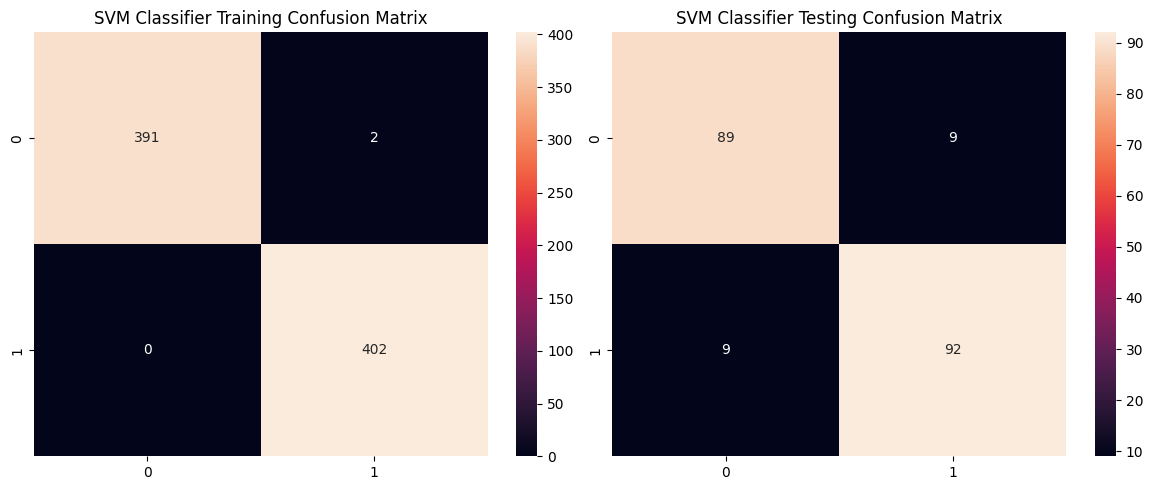

In [34]:
results = get_confusion_matrix('SVM Classifier',
                                roc_results)

In [35]:
metrics(results[0])

              precision    recall  f1-score   support

           0     0.9082    0.9082    0.9082        98
           1     0.9109    0.9109    0.9109       101

    accuracy                         0.9095       199
   macro avg     0.9095    0.9095    0.9095       199
weighted avg     0.9095    0.9095    0.9095       199

confusion matrix:  [0.90816327 0.91089109]
Accuracy: 0.9095477386934674
Recall:  0.9095271772075166
Precision:  0.9095271772075166
F1: 0.9095271772075166


### Binomial Naive Bayes 

In [36]:
bnb_model = BernoulliNB()
bnb_model.fit(X_train, y_train)
Ypredtest = bnb_model.predict_proba(X_test)[:,1]

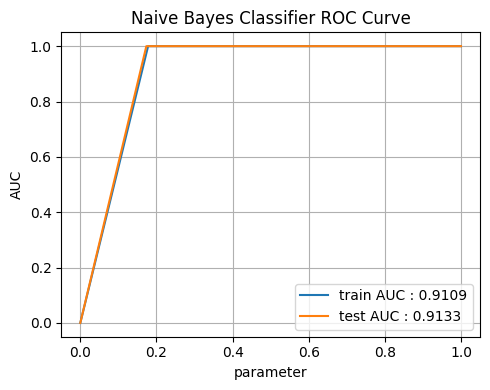

In [37]:
roc_results = get_roc_curve('Naive Bayes Classifier',
                             bnb_model)

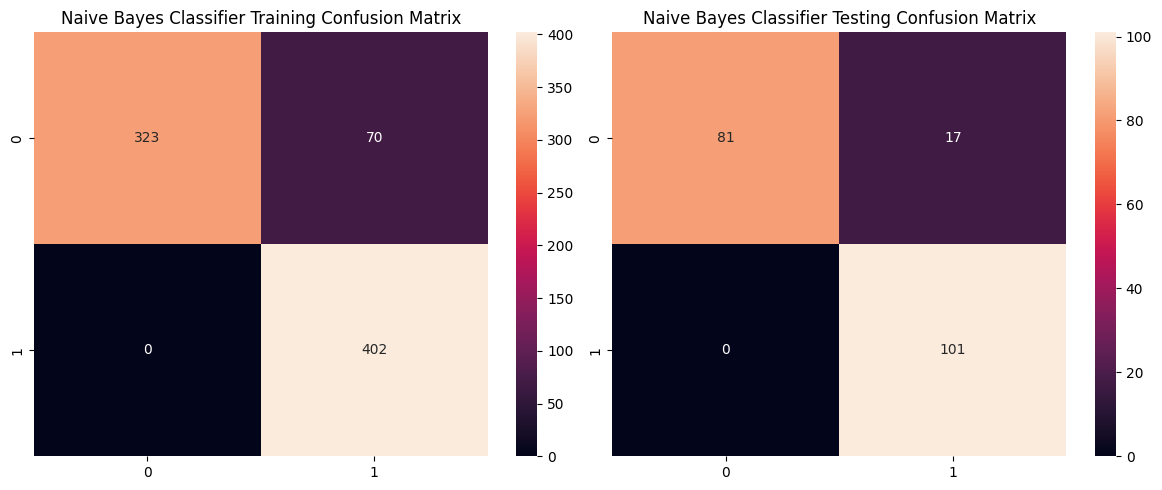

In [38]:
results = get_confusion_matrix('Naive Bayes Classifier',
                                roc_results)

In [39]:
metrics(results[0])

              precision    recall  f1-score   support

           0     1.0000    0.8265    0.9050        98
           1     0.8559    1.0000    0.9224       101

    accuracy                         0.9146       199
   macro avg     0.9280    0.9133    0.9137       199
weighted avg     0.9269    0.9146    0.9138       199

confusion matrix:  [0.82653061 1.        ]
Accuracy: 0.914572864321608
Recall:  0.9132653061224489
Precision:  0.9279661016949152
F1: 0.9137011810923191


In [40]:
import tabulate
print('Reddit Task P2 : TF vectors')
conclusion = [['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Train AUC', 'Test AUC', ],
              ['Logistic Regression', 91.9, 91.1, 92.0, 91.9],
              ['XGBoost Classifier', 94.9, 95.0, 95.0, 94.9],
              ['Random Forest Classifier', 95.4, 95.9, 95.4, 95.4],
              ['SVM Classifier', 90.9, 90.9, 90.9, 90.9],
              ['Naive Bayes Classifier',  91.4, 92.7, 91.3, 91.3],   
             ]
print(tabulate.tabulate(conclusion, tablefmt='fancy_grid'))

Task P2 : TF vectors - Model all-mpnet-base-v2
╒══════════════════════════╤══════════╤═══════════╤════════╤══════════╤═══════════╤══════════╕
│ Model                    │ Accuracy │ Precision │ Recall │ F1 Score │ Train AUC │ Test AUC │
├──────────────────────────┼──────────┼───────────┼────────┼──────────┼───────────┼──────────┤
│ Logistic Regression      │ 91.9     │ 91.1      │ 92.0   │ 91.9     │           │          │
├──────────────────────────┼──────────┼───────────┼────────┼──────────┼───────────┼──────────┤
│ XGBoost Classifier       │ 94.9     │ 95.0      │ 95.0   │ 94.9     │           │          │
├──────────────────────────┼──────────┼───────────┼────────┼──────────┼───────────┼──────────┤
│ Random Forest Classifier │ 95.4     │ 95.9      │ 95.4   │ 95.4     │           │          │
├──────────────────────────┼──────────┼───────────┼────────┼──────────┼───────────┼──────────┤
│ SVM Classifier           │ 90.9     │ 90.9      │ 90.9   │ 90.9     │           │          │
├──